<a href="https://colab.research.google.com/github/deepanshu650/Question-Answering-onSQuAD-using-BERT/blob/master/QuestionAnswering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# as you can see current ram is 12GB only, to increase it run below code

In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
# wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?

In [ ]:
# in the prompt click - yes

In [ ]:
# as you see the ram increase from 12GB to 25GB

In [ ]:
#thanks for watching, keep learning 

**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

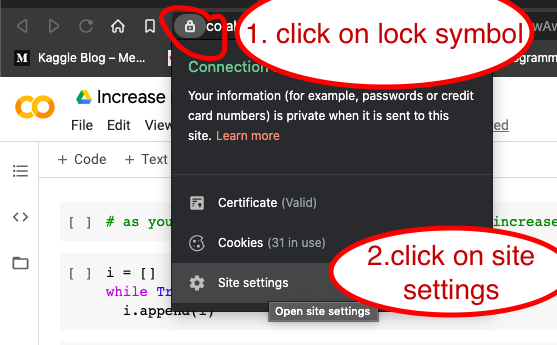

In [ ]:
#step-1

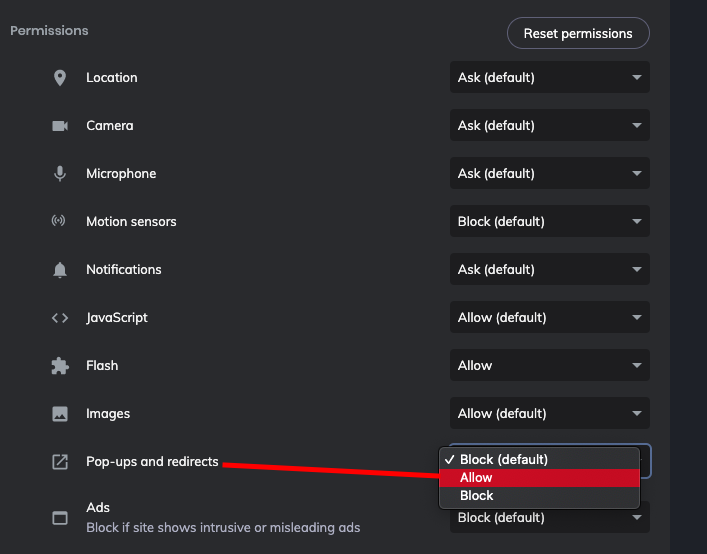

In [ ]:
#step-2

In [ ]:
!nvidia-smi

Sat Sep 19 04:55:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/huggingface/transformers \

Cloning into 'transformers'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42674 (delta 8), reused 8 (delta 2), pack-reused 42644
Receiving objects: 100% (42674/42674), 30.67 MiB | 30.26 MiB/s, done.
Resolving deltas: 100% (29537/29537), done.


In [ ]:
!pip install ./transformers
!pip install --upgrade transformers
!pip install tensorboardX

Processing ./transformers
     |████████████████████████████████| 3.0MB 2.9MB/s 
     |████████████████████████████████| 1.1MB 27.9MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
  Created wheel for transformers: filename=transformers-3.1.0-cp36-none-any.whl size=996650 sha256=5c7970cb9ca1a9a0a676568b055f341615e5d72554e8aca5936fbc9cbb17680d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6r95rsdi/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ae25b22ddad1b2d5d85cc29ebefccf4814f9358832ccbd71e52693f291a6b023
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built transformers sacremoses
Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (3.1.0)
     |████████████████████████████████| 317kB 3.0MB/s 


In [ ]:
import dataclasses
import logging
import os , time
import sys
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Union
import torch ,torch.nn as nn , torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
from typing import Dict, List, Optional, Union
from filelock import FileLock
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.modeling_auto import MODEL_FOR_QUESTION_ANSWERING_MAPPING
from transformers.utils import logging

import numpy as np
import json

from transformers.data.processors.squad import  SquadFeatures, SquadV1Processor, SquadV2Processor, squad_convert_examples_to_features
from transformers.data.datasets.squad import SquadDataTrainingArguments , SquadDataset
from transformers import AutoConfig, BertForSequenceClassification, BertTokenizer , BertForQuestionAnswering
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)

logger = logging.get_logger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


In [ ]:
#upload models to gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir dataset \
&& cd dataset \
&& wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json \
&& wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2020-09-19 05:05:34--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  49.5MB/s    in 0.8s    

2020-09-19 05:05:35 (49.5 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2020-09-19 05:05:35--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

### For question answering 

In [ ]:
#!python transformers/examples/question-answering/run_squad_trainer.py --help

In [ ]:
!python transformers/examples/question-answering/run_squad_trainer.py \
  --model_name_or_path bert-base-uncased \
  --model_type bert \
  --data_dir /content/dataset \
  --max_seq_length 384 \
  --version_2_with_negative \
  --threads 4 \
  --output_dir /content/model_qa_output \
  --do_train  \
  --do_eval  \
  --per_device_train_batch_size 12 \
  --num_train_epochs 2.0 \
  --save_steps 1000 \



Streaming output truncated to the last 5000 lines.
Iteration:  55% 6010/10996 [48:20<54:14,  1.53it/s]  
Iteration:  55% 6011/10996 [48:21<49:50,  1.67it/s]
Iteration:  55% 6012/10996 [48:21<46:46,  1.78it/s]
Iteration:  55% 6013/10996 [48:22<44:44,  1.86it/s]
Iteration:  55% 6014/10996 [48:22<43:10,  1.92it/s]
Iteration:  55% 6015/10996 [48:23<42:05,  1.97it/s]
Iteration:  55% 6016/10996 [48:23<41:17,  2.01it/s]
Iteration:  55% 6017/10996 [48:24<40:45,  2.04it/s]
Iteration:  55% 6018/10996 [48:24<40:32,  2.05it/s]
Iteration:  55% 6019/10996 [48:25<40:20,  2.06it/s]
Iteration:  55% 6020/10996 [48:25<40:03,  2.07it/s]
Iteration:  55% 6021/10996 [48:25<39:49,  2.08it/s]
Iteration:  55% 6022/10996 [48:26<39:44,  2.09it/s]
Iteration:  55% 6023/10996 [48:26<39:39,  2.09it/s]
Iteration:  55% 6024/10996 [48:27<39:31,  2.10it/s]
Iteration:  55% 6025/10996 [48:27<39:30,  2.10it/s]
Iteration:  55% 6026/10996 [48:28<39:32,  2.09it/s]
Iteration:  55% 6027/10996 [48:28<39:32,  2.09it/s]
Iteration: 

In [ ]:
# download model and config.json to your local machine from model_qa_output
#for present run
model_qa = BertForQuestionAnswering.from_pretrained('/content/model_qa_output/')

In [ ]:
# use this  after uploading model to gdrive
model_qa = BertForQuestionAnswering.from_pretrained('/content/drive/My Drive/model_qa')    
model_qa.eval()                
 

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
context =r""""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
    "When were transformers made?",
    "What is pytorch?",
    "Who is Trump?"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model_qa.to(device)

for question in questions:
  inputs = tokenizer(question ,context, add_special_tokens = True ,return_tensors = "pt").to(device)
  input_ids = inputs["input_ids"].tolist()[0]          #convert tensor to list
  start_score , end_score = model_qa(**inputs)
  ans_S = torch.argmax(start_score)
  ans_E = torch.argmax(end_score)
  answer = tokenizer.decode(input_ids[ans_S : ans_E+1],skip_special_tokens =True) 
  #answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[ans_S:ans_E+1]))

  print("Question : {}".format(question))
  if answer=="[CLS]" or answer=="":        #[CLS] comes when using second statement
    print("No Answer")
  else:
    print("Answer : {}".format(answer))



Question : How many pretrained models are available in 🤗 Transformers?
Answer : 32 +
Question : What does 🤗 Transformers provide?
Answer : general - purpose architectures
Question : 🤗 Transformers provides interoperability between which frameworks?
Answer : tensorflow 2. 0 and pytorch
Question : When were transformers made?
No Answer
Question : What is pytorch?
No Answer
Question : Who is Trump?
No Answer


### Use classification for classifying answer or no-answer

In [ ]:
from enum import Enum

class Split(Enum):
    train = "train"
    dev = "dev"

In [ ]:
class SquadNewDataset(SquadDataset):
    
    args: SquadDataTrainingArguments
    features: List[SquadFeatures]
    mode: Split
    is_language_sensitive: bool

    def __init__(
        self,
        args: SquadDataTrainingArguments,
        tokenizer: PreTrainedTokenizer,
        limit_length: Optional[int] = None,
        mode: Union[str, Split] = Split.train,
        is_language_sensitive: Optional[bool] = False,
        cache_dir: Optional[str] = None,
        dataset_format: Optional[str] = "pt",
        ensemble : Optional[bool] = False
    ):
        super().__init__(args,tokenizer)
        self.args = args
        self.is_language_sensitive = is_language_sensitive
        self.processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
        self.ensemble = ensemble
        if isinstance(mode, str):
            try:
                mode = Split[mode]
            except KeyError:
                raise KeyError("mode is not a valid split name")
        self.mode = mode
        # Load data features from cache or dataset file
        version_tag = "v2" if args.version_2_with_negative else "v1"
        cached_features_file = os.path.join(
            cache_dir if cache_dir is not None else args.data_dir,
            "cached_{}_{}_{}_{}".format(
                mode.value, tokenizer.__class__.__name__, str(args.max_seq_length), version_tag,
            ),
        )

        # Make sure only the first process in distributed training processes the dataset,
        # and the others will use the cache.
        lock_path = cached_features_file + ".lock"
        with FileLock(lock_path):
            if os.path.exists(cached_features_file) and not args.overwrite_cache:
                start = time.time()
                self.old_features = torch.load(cached_features_file)

                # Legacy cache files have only features, while new cache files
                # will have dataset and examples also.
                self.features = self.old_features["features"]
                self.dataset = self.old_features.get("dataset", None)
                self.examples = self.old_features.get("examples", None)
                logger.info(
                    f"Loading features from cached file {cached_features_file} [took %.3f s]", time.time() - start
                )

                if self.dataset is None or self.examples is None:
                    logger.warn(
                        f"Deleting cached file {cached_features_file} will allow dataset and examples to be cached in future run"
                    )
            else:
                if mode == Split.dev:
                    self.examples = self.processor.get_dev_examples(args.data_dir)              #these make list of SquadExample class
                else:                                                                           #from training or validation set
                    self.examples = self.processor.get_train_examples(args.data_dir)             

                self.features, self.dataset = squad_convert_examples_to_features(
                    examples=self.examples,
                    tokenizer=tokenizer,                                                       #This converts SquadExample list into
                    max_seq_length=args.max_seq_length,                                        #SquadFeatures class list
                    doc_stride=args.doc_stride,
                    max_query_length=args.max_query_length,
                    is_training=mode == Split.train,
                    threads=args.threads,
                    return_dataset=dataset_format,
                )

                start = time.time()
                torch.save(
                    {"features": self.features, "dataset": self.dataset, "examples": self.examples},
                    cached_features_file,
                )
                # ^ This seems to take a lot of time so I want to investigate why and how we can improve.
                logger.info(
                    "Saving features into cached file %s [took %.3f s]", cached_features_file, time.time() - start
                )

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        # Convert to Tensors and build dataset
        feature = self.features[i]

        input_ids = torch.tensor(feature.input_ids, dtype=torch.long)
        attention_mask = torch.tensor(feature.attention_mask, dtype=torch.long)
        token_type_ids = torch.tensor(feature.token_type_ids, dtype=torch.long)
        cls_index = torch.tensor(feature.cls_index, dtype=torch.long)
        p_mask = torch.tensor(feature.p_mask, dtype=torch.float)
        is_impossible = torch.tensor(feature.is_impossible, dtype=torch.long)
        qas_id = feature.qas_id 

        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "labels" : is_impossible
            
        }               

        #changed dataset from QuestionAnsweringModel to SequenceClassificationModel
        #labels will be provided for both training(for loss computation) and evaluate(for metric computation)
        if self.ensemble == True:
            inputs.update({"qas_id" : qas_id })

        return inputs 

In [ ]:
 model_classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased')
 model_classifier.train()
 tokenizer_classifier = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
data_args = SquadDataTrainingArguments(model_type = "bert " , data_dir = "/content/dataset" , max_seq_length = 384 , version_2_with_negative = True ,threads =4 )


In [ ]:
data_args = SquadDataTrainingArguments(model_type = "bert " , data_dir = "/content/dataset" , max_seq_length = 384 , version_2_with_negative = True ,threads =4 )

#create dataset 
train_dataset = SquadNewDataset(data_args, tokenizer_classifier, mode= 'train')

convert squad examples to features:   0%|          | 0/130319 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  F

In [ ]:
eval_dataset = SquadNewDataset(data_args, tokenizer_classifier, mode= 'dev') 

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/model_output_classifier",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_gpu_train_batch_size=8,
    per_gpu_eval_batch_size=8,
    learning_rate = 2e-5,
    num_train_epochs=2,
    logging_steps=500,
    logging_first_step=True,
    save_steps=1000,)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)                ##(batch_size, config.num_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
#if no compute_metric provided eval_loss will be given

In [ ]:
trainer = Trainer(                                              #Trainer has it's own dataloader
                  model = model_classifier ,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = eval_dataset,
                  compute_metrics = compute_metrics 

)

In [ ]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


{'loss': 0.002086109161376953, 'learning_rate': 1.9999393682168194e-05, 'epoch': 6.0631783180743344e-05, 'total_flos': 2018004996096, 'step': 1}
{'loss': 0.6464555168151855, 'learning_rate': 1.9696841084096287e-05, 'epoch': 0.030315891590371673, 'total_flos': 1009002498048000, 'step': 500}
{'loss': 0.575720947265625, 'learning_rate': 1.939368216819257e-05, 'epoch': 0.060631783180743345, 'total_flos': 2018004996096000, 'step': 1000}


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


{'loss': 0.524669189453125, 'learning_rate': 1.909052325228885e-05, 'epoch': 0.09094767477111503, 'total_flos': 3027007494144000, 'step': 1500}
{'loss': 0.4917476806640625, 'learning_rate': 1.8787364336385136e-05, 'epoch': 0.12126356636148669, 'total_flos': 4036009992192000, 'step': 2000}
{'loss': 0.4862197265625, 'learning_rate': 1.8484205420481418e-05, 'epoch': 0.15157945795185837, 'total_flos': 5045012490240000, 'step': 2500}
{'loss': 0.46780322265625, 'learning_rate': 1.8181046504577703e-05, 'epoch': 0.18189534954223005, 'total_flos': 6054014988288000, 'step': 3000}
{'loss': 0.4519638671875, 'learning_rate': 1.7877887588673985e-05, 'epoch': 0.2122112411326017, 'total_flos': 7063017486336000, 'step': 3500}
{'loss': 0.4444775390625, 'learning_rate': 1.7574728672770267e-05, 'epoch': 0.24252713272297338, 'total_flos': 8072019984384000, 'step': 4000}
{'loss': 0.428974853515625, 'learning_rate': 1.7271569756866552e-05, 'epoch': 0.27284302431334506, 'total_flos': 9081022482432000, 'step':

{'loss': 0.3640009765625, 'learning_rate': 9.995755775177349e-06, 'epoch': 1.0004244224822652, 'total_flos': 33297082435584000, 'step': 16500}
{'loss': 0.3006806640625, 'learning_rate': 9.692596859273632e-06, 'epoch': 1.0307403140726368, 'total_flos': 34306084933632000, 'step': 17000}
{'loss': 0.3056376953125, 'learning_rate': 9.389437943369916e-06, 'epoch': 1.0610562056630086, 'total_flos': 35315087431680000, 'step': 17500}
{'loss': 0.302091796875, 'learning_rate': 9.086279027466198e-06, 'epoch': 1.0913720972533802, 'total_flos': 36324089929728000, 'step': 18000}
{'loss': 0.3166103515625, 'learning_rate': 8.783120111562483e-06, 'epoch': 1.1216879888437519, 'total_flos': 37333092427776000, 'step': 18500}
{'loss': 0.29890234375, 'learning_rate': 8.479961195658765e-06, 'epoch': 1.1520038804341235, 'total_flos': 38342094925824000, 'step': 19000}
{'loss': 0.30198046875, 'learning_rate': 8.176802279755048e-06, 'epoch': 1.1823197720244951, 'total_flos': 39351097423872000, 'step': 19500}
{'lo

TrainOutput(global_step=32986, training_loss=0.3614312108735524)

In [ ]:
trainer.evaluate()           #squad dataset can't be evaluated using this since squadDataset doesn't gives labels when used in evaluation mode
                             #it'll generate output file which can then be evaluated seprately 
                             #otherwise this checks for 'label' and give input accordingly and compute loss , logits , metric

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.



{'eval_loss': 1.2150075311532196, 'eval_accuracy': 0.6994767822105952, 'eval_f1': 0.6361836896278702, 'eval_precision': 0.8085534591194968, 'eval_recall': 0.524392233643335, 'epoch': 2.0, 'total_flos': 66565912801222656, 'step': 32986}


{'epoch': 2.0,
 'eval_accuracy': 0.6994767822105952,
 'eval_f1': 0.6361836896278702,
 'eval_loss': 1.2150075311532196,
 'eval_precision': 0.8085534591194968,
 'eval_recall': 0.524392233643335,
 'total_flos': 66565912801222656}

In [ ]:
model_classifier.save_pretrained('/content/saved_model_2')  #and download for future use

In [ ]:
#upload and use saved model
model_classifier = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/model_classifier')
model_classifier.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#can try trainer.predict() also

model_classifier.to(device)

for question in questions:
  inputs = tokenizer(question , context , return_tensors="pt").to(device)
  scores = model_classifier(**inputs)
  probability = F.softmax(scores[0] , dim=1)                                  
  prob , index = probability.max(dim= 1)                                 #dim of prob,index is (batch_size)
  print("Question : {}".format(question))
  print("is_impossible : {}".format(index))                              #1 for impossible i.e, don't have answer and 0 if have answer
  print("probability : {}".format(prob))


Question : How many pretrained models are available in 🤗 Transformers?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.9941], device='cuda:0', grad_fn=<MaxBackward0>)
Question : What does 🤗 Transformers provide?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.9960], device='cuda:0', grad_fn=<MaxBackward0>)
Question : 🤗 Transformers provides interoperability between which frameworks?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.9934], device='cuda:0', grad_fn=<MaxBackward0>)
Question : When were transformers made?
is_impossible : tensor([1], device='cuda:0')
probability : tensor([0.9600], device='cuda:0', grad_fn=<MaxBackward0>)
Question : What is pytorch?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.9881], device='cuda:0', grad_fn=<MaxBackward0>)
Question : Who is Trump?
is_impossible : tensor([1], device='cuda:0')
probability : tensor([0.9987], device='cuda:0', grad_fn=<MaxBackward0>)


## Ensemble the two models

In [ ]:
batch_size = 32
tokenizer_classifier = BertTokenizer.from_pretrained('bert-base-uncased')
ensemble_train_dataset = SquadNewDataset(data_args, tokenizer_classifier, mode= "train" , ensemble = True)


convert squad examples to features:   0%|          | 0/130319 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  F

In [ ]:
ensemble_valid_dataset = SquadNewDataset(data_args, tokenizer_classifier, mode= "dev" , ensemble = True) 


convert squad examples to features:   0%|          | 0/11873 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  Fu

In [ ]:
train_loader = DataLoader(ensemble_train_dataset , batch_size = batch_size , shuffle = True)   
eval_loader = DataLoader(ensemble_valid_dataset ,batch_size = batch_size , shuffle = True )

In [ ]:
next(train_loader.__iter__())

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[ 101, 2040, 6427,  ...,    0,    0,    0],
         [ 101, 2029, 2161,  ...,    0,    0,    0],
         [ 101, 2247, 2007,  ...,    0,    0,    0],
         ...,
         [ 101, 2129, 2001,  ...,    0,    0,    0],
         [ 101, 2054, 4988,  ...,    0,    0,    0],
         [ 101, 2043, 2106,  ...,    0,    0,    0]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0]),
 'qas_id': ['570c660afed7b91900d45999',
  '56d369ca59d6e41400146321',
  '56fad4558f12f319006301d4',
  '56f88e4aaef237190062618a',
  '5726dea95951b619008f80b5',
  '572699c4dd62a815002e8ab4',
  '5a67a352f038b7001ab0c3b0',
  '5ad190ec645df0001a2d1fa9',
  '5a66faa1f038b7001ab0c144',
  '

In [ ]:
#the classifier is going to help in telling weather there is answer or not along with the QuestionAnswerModel's prediction for that, 
#and then accordingly final "answer", to the question is generated by QuestionAnswerModel itself
class MyEnsemble(nn.Module):
  def __init__(self, model_classifier , model_qa):
    super().__init__()

    self.model_classifier = model_classifier
    self.model_qa = model_qa
    self.linear_classifier = nn.Linear(4,2)

  def get_probs(self  ,start_score , end_score ,batch_size=32):
    t = 0                                                            #check in the bert paper about this h.para. and find tune it for some value 
    start_score , end_score = start_score , end_score
    size = start_score.size(0)
    start_prob = F.softmax(start_score, dim=1)
    end_prob = F.softmax(end_score , dim=1)
    start_null = start_prob[:,0]                                     #0 index of seq_length corresponds to [CLS]
    end_null = end_prob[:,0]
    null_prob = start_null + end_null

    best_score_prob = start_prob.max(dim =1)[0] + end_prob.max(dim =1)[0]
    prob = torch.zeros((size , 2)).to(device)
    for batch in range(size):
      if best_score_prob[batch]>(null_prob[batch] + t) :
        prob[batch][0] = best_score_prob[batch]/2                     #assuming index 0 for label 0 and giving average as prob.
        prob[batch][1] = 1 - prob[batch][0]                           #index 0 for having answer in prob tensor

      else :
        prob[batch][1] = null_prob[batch]/2
        prob[batch][0] = 1 - prob[batch][1]

    return prob

  
  def forward(self ,batch_size=32 ,**x ):
    input = x
    x1 = self.model_classifier(**input)
    x1 = F.softmax(x1[0] , dim =1)
    start_score , end_score = self.model_qa(**input)
    prob = self.get_probs( start_score , end_score ,batch_size)
    x = torch.cat([x1 , prob] , dim=1)
    x = self.linear_classifier(x)
    x = F.softmax(x , dim=1)
    return x




In [ ]:
#freeze both models parameters
for para in model_qa.parameters():
  para.requires_grad = False

for para in model_classifier.parameters():
  para.requires_grad = False

In [ ]:
ensemble = MyEnsemble(model_classifier , model_qa)
ensemble.to(device)

import torch.optim as optim
optimizer = optim.Adam(ensemble.parameters())

In [ ]:
epochs = 3

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('ensemble')

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [ ]:
ensemble.train()

for epoch in range(epochs):
  
  running_loss = 0
  for i , data in enumerate(train_loader):
     target = data['labels'].to(device)
     input = {}
     input['input_ids'] = data['input_ids'].to(device)                          
     input['attention_mask'] = data['attention_mask'].to(device)
     input['token_type_ids'] = data['token_type_ids'].to(device)             #no need of qas_id this time
     optimizer.zero_grad()
     
     output = ensemble(**input)
     loss = F.cross_entropy(output , target)
     loss.backward()
     optimizer.step()
     
     running_loss += loss.item() 
     if (i+1)%20==0 :
       writer.add_scalar('training_loss' , running_loss/20 , epoch*len(train_loader)+i)
       print('[%d  ,  %5d]  loss = %.3f' %(epoch+1, i+1 , running_loss/10))
       running_loss =0

writer.close()
print('Finished Training...')

[1  ,     20]  loss = 1.589
[1  ,     40]  loss = 1.550
[1  ,     60]  loss = 1.492
[1  ,     80]  loss = 1.445
[1  ,    100]  loss = 1.372
[1  ,    120]  loss = 1.345
[1  ,    140]  loss = 1.276
[1  ,    160]  loss = 1.228
[1  ,    180]  loss = 1.152
[1  ,    200]  loss = 1.109
[1  ,    220]  loss = 1.054
[1  ,    240]  loss = 0.999
[1  ,    260]  loss = 0.958
[1  ,    280]  loss = 0.930
[1  ,    300]  loss = 0.905
[1  ,    320]  loss = 0.878
[1  ,    340]  loss = 0.854
[1  ,    360]  loss = 0.854
[1  ,    380]  loss = 0.819
[1  ,    400]  loss = 0.812
[1  ,    420]  loss = 0.788
[1  ,    440]  loss = 0.786
[1  ,    460]  loss = 0.789
[1  ,    480]  loss = 0.770
[1  ,    500]  loss = 0.781
[1  ,    520]  loss = 0.769
[1  ,    540]  loss = 0.753
[1  ,    560]  loss = 0.752
[1  ,    580]  loss = 0.761
[1  ,    600]  loss = 0.742
[1  ,    620]  loss = 0.742
[1  ,    640]  loss = 0.757
[1  ,    660]  loss = 0.730
[1  ,    680]  loss = 0.731
[1  ,    700]  loss = 0.738
[1  ,    720]  loss 

KeyboardInterrupt: ignored

In [ ]:
#check the ensemble model ability to classify
for question in questions:
  inputs = tokenizer_classifier(question , context , return_tensors="pt").to(device)
  probability = ensemble(batch_size=1 ,**inputs )                                  
  prob , index = probability.max(dim= 1)                                   #dim of prob,index is (batch_size)
  print("Question : {}".format(question))
  print("is_impossible : {}".format(index))
  print("probability : {}".format(prob))


Question : How many pretrained models are available in 🤗 Transformers?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.9999], device='cuda:0', grad_fn=<MaxBackward0>)
Question : What does 🤗 Transformers provide?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)
Question : 🤗 Transformers provides interoperability between which frameworks?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)
Question : When were transformers made?
is_impossible : tensor([1], device='cuda:0')
probability : tensor([0.9970], device='cuda:0', grad_fn=<MaxBackward0>)
Question : What is pytorch?
is_impossible : tensor([0], device='cuda:0')
probability : tensor([0.8881], device='cuda:0', grad_fn=<MaxBackward0>)
Question : Who is Trump?
is_impossible : tensor([1], device='cuda:0')
probability : tensor([0.9999], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
torch.save(ensemble.state_dict() , 'SQuAD_model.pth')

In [ ]:
#save the model in json file for further evaluation
ensemble.eval()

json_dict = {}

for i , data in enumerate(eval_loader):
  input = {}
  input['input_ids'] = data['input_ids'].to(device)                             
  input['attention_mask'] = data['attention_mask'].to(device)
  input['token_type_ids'] = data['token_type_ids'].to(device)           #no need of label this time
  qas_id = data['qas_id']

  predictions = ensemble(**input)
  predictions = predictions.max(dim = 1)[1]
  prediction_size = predictions.size(0)
  
  for batch in range(prediction_size):
     inputs = {}
     if predictions[batch] == 1 :                           #if no answer then " " else give the answer
        json_dict[qas_id[batch]] = " "
     
     else :
        inputs['input_ids'] = input['input_ids'][batch].unsqueeze(0).to(device)
        inputs['attention_mask'] = input['attention_mask'][batch].unsqueeze(0).to(device)
        inputs['token_type_ids'] = input['token_type_ids'][batch].unsqueeze(0).to(device)
        inputs_ids = inputs['input_ids'].tolist()[0] 
        start_score, end_score = model_qa(**inputs)
        ans_S = torch.argmax(start_score)
        ans_E = torch.argmax(end_score)
        answer = tokenizer_classifier.decode(inputs_ids[ans_S : ans_E +1] , skip_special_tokens = True)
        json_dict[qas_id[batch]] = str(answer)

     
with open("SQuAD_predictions.json" , "w") as outfile:
   json.dump(json_dict , outfile)


After this evaluate this json file using evaluator at official SQuAD page .


Results are approx

exact answers : 69.33

f1 : 73.33
